In [1]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
df = pd.read_csv('kaggle_london_house_price_data.zip')
df.head()

,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,...,saleEstimate_upperPrice,saleEstimate_confidenceLevel,saleEstimate_ingestedAt,saleEstimate_valueChange.numericChange,saleEstimate_valueChange.percentageChange,saleEstimate_valueChange.saleDate,history_date,history_price,history_percentageChange,history_numericChange
0,"Flat 9, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,1.0,1.0,45.0,1.0,...,630000.0,HIGH,2024-10-07T13:26:59.894Z,244000.0,68.539326,2010-03-30,1995-01-02,830000,NaN,NaN
1,"Flat 6, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,NaN,NaN,NaN,NaN,...,660000.0,MEDIUM,2024-10-07T13:26:59.894Z,425000.0,242.857143,2000-05-26,1995-01-02,830000,NaN,NaN
2,"Flat 35, Octavia House, Medway Street, London,...",SW1P 2TA,England,SW1P,51.495505,-0.132379,2.0,2.0,71.0,1.0,...,834000.0,MEDIUM,2025-01-10T11:04:57.114Z,49000.0,6.901408,2019-09-04,1995-01-03,249950,NaN,NaN
3,"24 Chester Court, Lomond Grove, London, SE5 7HS",SE5 7HS,England,SE5,51.478185,-0.092201,1.0,1.0,64.0,1.0,...,407000.0,HIGH,2024-10-07T13:26:59.894Z,28000.0,7.777778,2024-01-25,1995-01-03,32000,NaN,NaN
4,"18 Alexandra Gardens, London, N10 3RL",N10 3RL,England,N10,51.588774,-0.139599,1.0,4.0,137.0,2.0,...,1324000.0,HIGH,2024-10-07T13:26:59.894Z,81000.0,6.864407,2022-12-14,1995-01-03,133000,NaN,NaN


In [3]:
cols_to_drop = [
    'fullAddress',                     # Too granular
    'postcode',                        # High cardinality
    'country',                         # No predictive power
    'saleEstimate_ingestedAt',         # Model outputs or metadata
    'rentEstimate_lowerPrice',         # Model outputs or metadata
    'rentEstimate_currentPrice',       # Model outputs or metadata
    'rentEstimate_upperPrice',         # Model outputs or metadata
    'saleEstimate_lowerPrice',         # confidence bounds, not needed
    'saleEstimate_upperPrice',         # confidence bounds, not needed
    'saleEstimate_confidenceLevel',    # confidence bounds, not needed
    'saleEstimate_valueChange.numericChange',   # Too noisy
    'saleEstimate_valueChange.percentageChange',# Too noisy
    'saleEstimate_valueChange.saleDate',        # Too noisy
    'history_date',                    # Too noisy
    'history_price',                   # Too noisy
    'history_percentageChange',        # Too noisy
    'history_numericChange'            # Too noisy
]

# Drop safely even if some columns are missing
df = df.drop(columns=cols_to_drop, errors='ignore')


In [4]:
df.describe()

,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,saleEstimate_currentPrice
count,418201.000000,418201.000000,340270.000000,377665.000000,392991.000000,357701.000000,4.175610e+05
mean,51.507522,-0.101426,1.444265,2.474884,98.926543,1.282275,9.045188e+05
std,0.056171,0.086930,0.724478,1.160506,55.938911,0.574412,9.202917e+05
min,51.385708,-0.347055,1.000000,1.000000,10.000000,1.000000,8.900000e+04
25%,51.464315,-0.155996,1.000000,2.000000,63.000000,1.000000,4.460000e+05
50%,51.501581,-0.108482,1.000000,2.000000,84.000000,1.000000,6.220000e+05
75%,51.548515,-0.043582,2.000000,3.000000,116.000000,1.000000,9.840000e+05
max,51.665823,0.139249,9.000000,9.000000,500.000000,9.000000,2.922000e+07


In [5]:
df.duplicated().sum()

np.int64(240002)

In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
df_missing_value = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
df_missing_value.sort_values('percent_missing', inplace=True)
df_missing_value

,column_name,percent_missing
outcode,outcode,0.000000
latitude,latitude,0.000000
longitude,longitude,0.000000
saleEstimate_currentPrice,saleEstimate_currentPrice,0.153036
propertyType,propertyType,0.271640
tenure,tenure,2.752743
floorAreaSqM,floorAreaSqM,6.028202
bedrooms,bedrooms,9.692947
livingRooms,livingRooms,14.466728
bathrooms,bathrooms,18.634819


In [7]:
# For numeric features, i will be using imputation which is robust to outliers.
# Additionally, London property distributions (bedrooms, bathrooms, floor area) are typically skewed, not symmetric — mean will be distorted.
# For categorical features, I will use 'Unkwown' for consistency

for c in ["floorAreaSqM", "bedrooms", "livingRooms", "bathrooms"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c] = df[c].fillna(df[c].median())

# categoricals -> "Unknown"
for c in ["propertyType", "tenure", "currentEnergyRating"]:
    if c in df.columns:
        df[c] = df[c].astype("string").fillna("Unknown")

In [8]:
df.isna().sum()

outcode                        0
latitude                       0
longitude                      0
bathrooms                      0
bedrooms                       0
floorAreaSqM                   0
livingRooms                    0
tenure                         0
propertyType                   0
currentEnergyRating            0
saleEstimate_currentPrice    640
dtype: int64

In [9]:
df = df.dropna(subset=['saleEstimate_currentPrice']) #Dropping the missing Target Variable
df = df.rename(columns={'outcode': 'postcodeArea'}) # Renaming outcode for clarity
df.head()

,postcodeArea,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,tenure,propertyType,currentEnergyRating,saleEstimate_currentPrice
0,EC4A,51.517282,-0.110314,1.0,1.0,45.0,1.0,Leasehold,Purpose Built Flat,Unknown,600000.0
1,EC4A,51.517282,-0.110314,1.0,2.0,84.0,1.0,Leasehold,Flat/Maisonette,Unknown,600000.0
2,SW1P,51.495505,-0.132379,2.0,2.0,71.0,1.0,Leasehold,Flat/Maisonette,C,759000.0
3,SE5,51.478185,-0.092201,1.0,1.0,64.0,1.0,Leasehold,Flat/Maisonette,D,388000.0
4,N10,51.588774,-0.139599,1.0,4.0,137.0,2.0,Freehold,End Terrace House,D,1261000.0


In [10]:
# Check remaining missing values in features
df.isna().sum().sort_values(ascending=False)

# Check target distribution
df['saleEstimate_currentPrice'].describe()

# Check dataset size
df.shape


(417561, 11)

### Target Variable Exploration.¶ The Goal here is See if prices are skewed (they usually are in London)


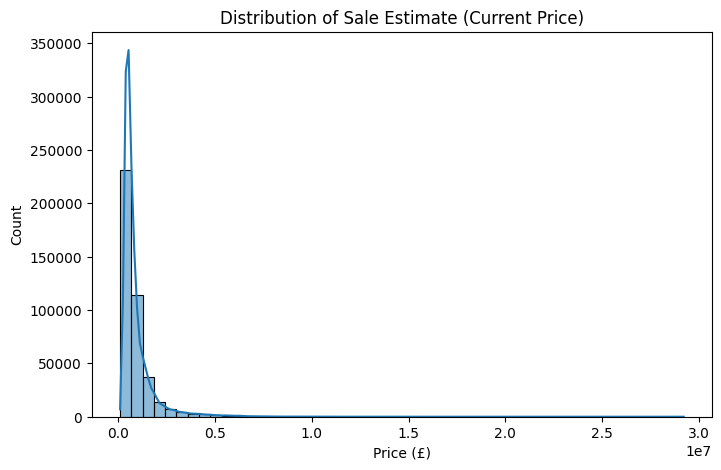

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df['saleEstimate_currentPrice'], bins=50, kde=True)
plt.title("Distribution of Sale Estimate (Current Price)")
plt.xlabel("Price (£)")
plt.show()

### Feature Distributions (Numerics). The goal here is to spot unusual spikes, outliers, or unrealistic values.

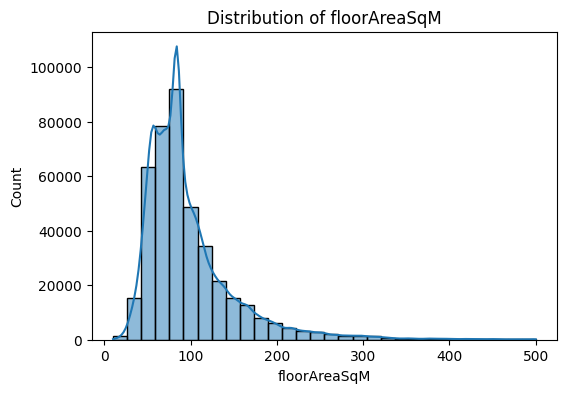

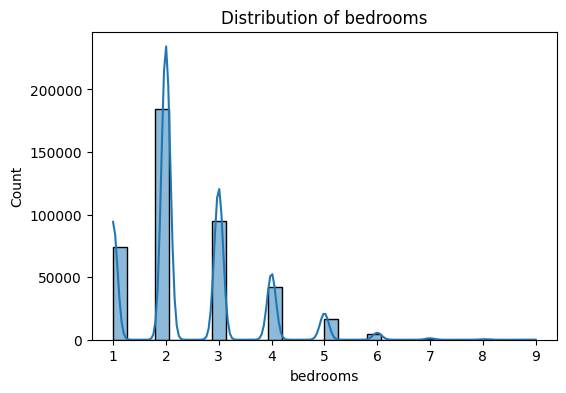

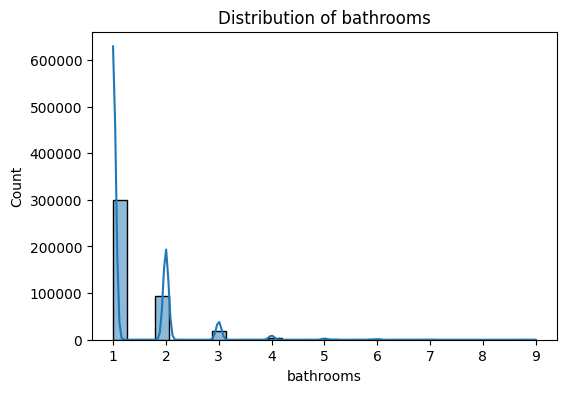

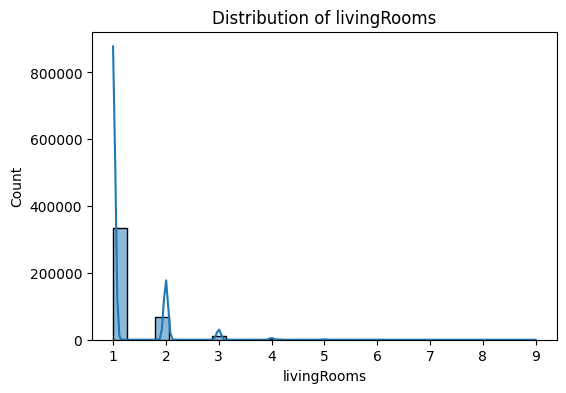

In [12]:
numeric_cols = ['floorAreaSqM', 'bedrooms', 'bathrooms', 'livingRooms']

for col in numeric_cols:
    plt.figure(figsize = (6,4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

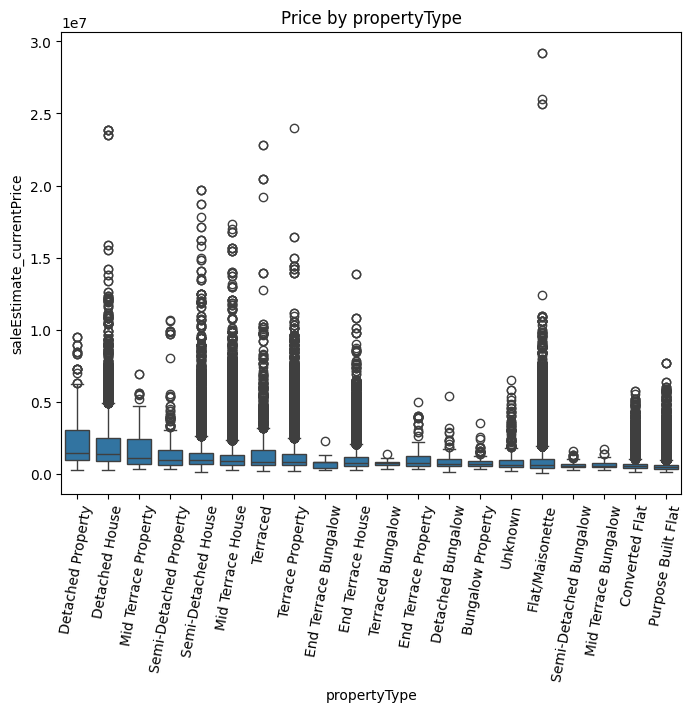

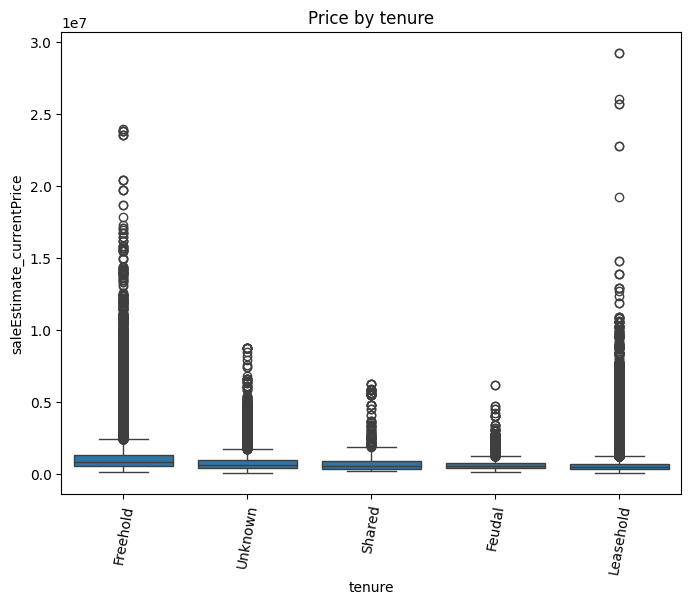

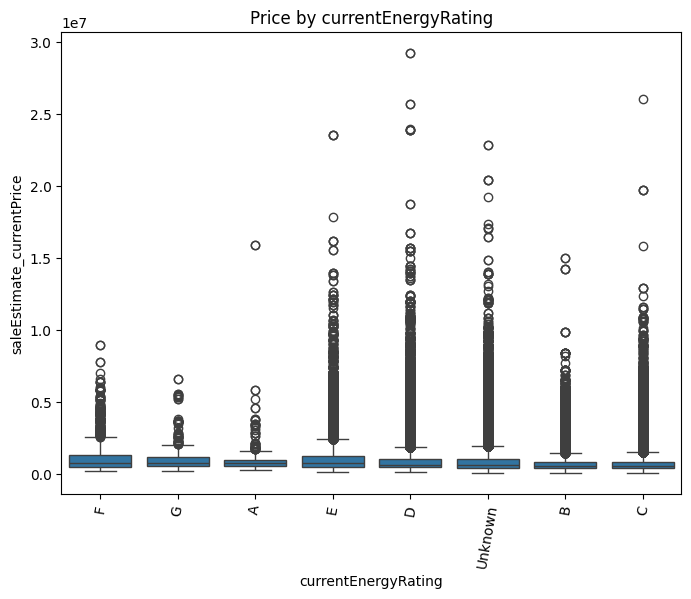

In [13]:
cat_cols = ['propertyType', 'tenure', 'currentEnergyRating']

for col in cat_cols:
    plt.figure(figsize=(8,6))
    order = df.groupby(col)['saleEstimate_currentPrice'].median().sort_values(ascending=False).index
    sns.boxplot(x=col, y='saleEstimate_currentPrice', data=df, order=order)
    plt.xticks(rotation=80)
    plt.title(f"Price by {col}")
    plt.show()

### Price by Top postcodeArea: The goal here is to spot geographic premium areas.

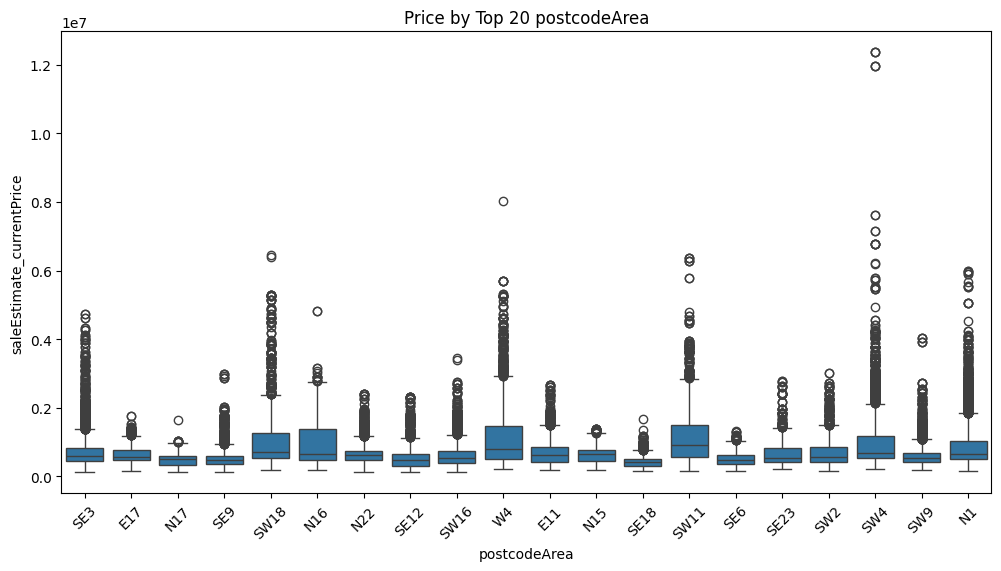

In [14]:
top_postcodeArea = df['postcodeArea'].value_counts().head(20).index
plt.figure(figsize=(12,6))
sns.boxplot(x='postcodeArea', y='saleEstimate_currentPrice', data=df[df['postcodeArea'].isin(top_postcodeArea)])
plt.xticks(rotation=45)
plt.title("Price by Top 20 postcodeArea")
plt.show()

### Correlation Heatmap (Numeric) Goal: Spot strongest numeric predictors.

In [15]:
corr = df.corr(numeric_only=True)
corr

,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,saleEstimate_currentPrice
latitude,1.000000,-0.014590,0.018954,0.008537,0.018980,0.041987,0.020182
longitude,-0.014590,1.000000,-0.171448,-0.059382,-0.137913,-0.019680,-0.271740
bathrooms,0.018954,-0.171448,1.000000,0.547581,0.572888,0.407404,0.509162
bedrooms,0.008537,-0.059382,0.547581,1.000000,0.732883,0.522250,0.452861
floorAreaSqM,0.018980,-0.137913,0.572888,0.732883,1.000000,0.547634,0.675550
livingRooms,0.041987,-0.019680,0.407404,0.522250,0.547634,1.000000,0.389120
saleEstimate_currentPrice,0.020182,-0.271740,0.509162,0.452861,0.675550,0.389120,1.000000


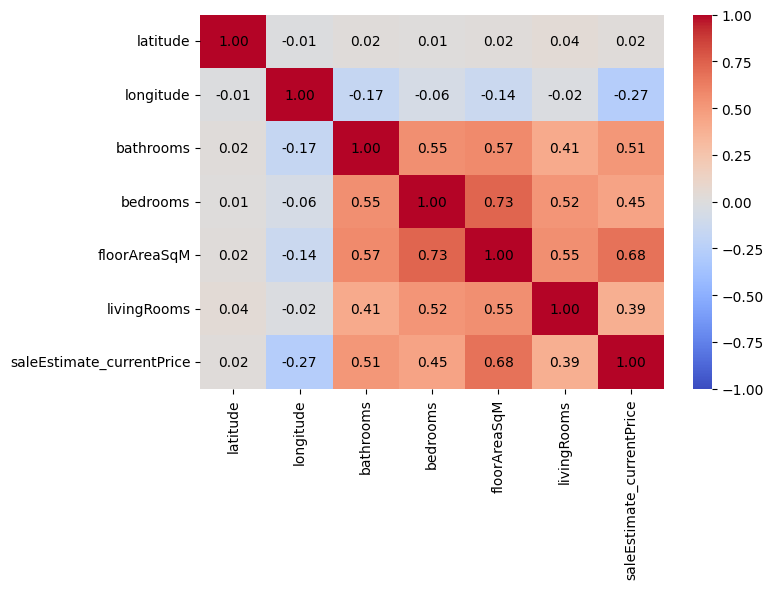

In [16]:
import numpy as np
fig, ax = plt.subplots(figsize=(8,6))
im = sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
for y in range(corr.shape[0]):
    for x in range(corr.shape[1]):
        v = corr.iat[y, x]
        if np.isfinite(v):
            ax.text(x + 0.5, y + 0.5, f'{v:.2f}', ha='center', va='center', color='black')
fig.tight_layout(); plt.show()

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 42

# Define the target column name
TARGET_COLUMN = 'saleEstimate_currentPrice'

# Clean and convert the target column to float
y = df[TARGET_COLUMN].astype(str).str.replace('[£,]','', regex=True).astype(float)

NUMERIC = ["latitude", "longitude", "floorAreaSqM", "bedrooms", "bathrooms", "livingRooms"]
CATEGORICAL = ["propertyType", "tenure", "currentEnergyRating", "postcodeArea"]

X = df[NUMERIC + CATEGORICAL].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [18]:
# Function to log-transform skewed numeric columns
def log_transform(x):
    return np.log1p(x) # handles zero values safely (unlike plain np.log(x) which fails on 0), hence  good for right-skewed data, making distributions closer to normal.
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),       # handle missing nums
    ("log", FunctionTransformer(log_transform, validate=False)),  # normalize skew
    ("scaler", StandardScaler()),                        # scale to std. normal
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # handle missing cats
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # safe OHE
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUMERIC),
        ("cat", categorical_pipe, CATEGORICAL)
    ]
)

### Model Evaluation

In [21]:

def evaluate(model, name):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    median_price = y_test.median()
    rmse_pct = (rmse / median_price) * 100
    mae_pct = (mae / median_price) * 100

    print(f"{name}  RMSE: £{rmse:,.0f} ({rmse_pct:.2f}%) | "
          f"MAE: £{mae:,.0f} ({mae_pct:.2f}%) | "
          f"R²: {r2:0.3f}")

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
import numpy as np


# Random Forest (RandomizedSearchCV, 20 trials)

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

rf_param_dist = {
    "reg__n_estimators": randint(100, 401),          
    "reg__max_depth": [None] + list(range(8, 26)),   
    "reg__min_samples_split": randint(2, 21),        
    "reg__min_samples_leaf": randint(1, 11),         
    "reg__max_features": ["sqrt", "log2", 0.5],      
}

rf_search = RandomizedSearchCV(
    rf, rf_param_dist,
    n_iter=20,              
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

rf_search.fit(X_train, y_train)
evaluate(rf_search.best_estimator_, "Random Forest (RS 20)")
rf_best = rf_search.best_estimator_


# XGBoost (RandomizedSearchCV, 20 trials)

xgb = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", XGBRegressor(
        random_state=RANDOM_STATE,
        objective="reg:squarederror",
        tree_method="hist",   
        n_estimators=600,     
        n_jobs=-1
    ))
])

xgb_param_dist = {
    "reg__max_depth": randint(3, 10),                 
    "reg__learning_rate": uniform(0.03, 0.12-0.03), 
    "reg__subsample": uniform(0.7, 0.3),            
    "reg__colsample_bytree": uniform(0.7, 0.3),     
    "reg__min_child_weight": randint(1, 7),         
    "reg__gamma": uniform(0.0, 0.3),                 
    "reg__reg_lambda": uniform(0.0, 1.0),             
    "reg__reg_alpha": uniform(0.0, 0.5),              
}

xgb_search = RandomizedSearchCV(
    xgb, xgb_param_dist,
    n_iter=20,              
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

xgb_search.fit(X_train, y_train)
evaluate(xgb_search.best_estimator_, "XGBoost (RS 20)")
xgb_best = xgb_search.best_estimator_


# Select best on the test set

def test_rmse(model):
    p = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, p))

candidates = [("Random Forest", rf_best), ("XGBoost", xgb_best)]
best_name, best_model = min(candidates, key=lambda t: test_rmse(t[1]))
print(f"Best model on test set: {best_name}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Random Forest (RS 20)  RMSE: £227,846 (36.51%) | MAE: £84,858 (13.60%) | R²: 0.939
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost (RS 20)  RMSE: £236,945 (37.97%) | MAE: £108,941 (17.46%) | R²: 0.934
Best model on test set: Random Forest


### Pickling The Model file for Deployment

In [23]:
import pickle

model_path = f"best_{best_name.replace(' ', '_').lower()}.pkl"
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)
print("Saved:", model_path)


Saved: best_random_forest.pkl


In [24]:
with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)

# take a small batch from X_test and predict
sample = X_test.iloc[:5].copy()
pred = loaded_model.predict(sample)
print("Sample predictions:", pred)

Sample predictions: [ 450734.47576493  487930.91728015 3367822.37689603 2437177.3949639
  445027.74513678]
